## 1.Load Task in Benchmark Quickly

Tutorial one is to load a task/env conveniently by simply giving task name and desired target embodiment (default is Franka).

In [1]:
import os

from dm_control import viewer
from PIL import Image
from VLABench.envs import load_env
from VLABench.robots import *
from VLABench.tasks import *

/home/pavan.kandapagari/.local/lib/python3.10/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/home/pavan.kandapagari/.local/lib/python3.10/site-packages/dash/_jupyter.py:30: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  _dash_comm = Comm(target_name="dash")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Set the embodiment and task 

In [2]:
task = "select_fruit"
robot = "franka"

If run this tutorial on server instead of PC, run in headless mode.

In [8]:
os.environ["MUJOCO_GL"] = "egl"

###  1.1Load task and build environment

Each time you load the single env, each instance varies in a large range.

In [9]:
env = load_env(task, robot=robot, time_limit=1000)
env.reset()

image = env.render(camera_id=1, width=224, height=224)
Image.fromarray(image)

FatalError: gladLoadGL error

In [10]:
obs=env.get_observation()
obs

FatalError: gladLoadGL error

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoProcessor


processor_path = "/home/pavan.kandapagari/Documents/Gitlab/agile-vla-pytorch/data/arivu-4b-base"
processor = AutoProcessor.from_pretrained(processor_path, use_fast=True)

In [ ]:
def pad_to_length(tensor, length, dim=0, value=0.0):
    pad_size = [0] * (2 * tensor.dim())
    pad_len = length - tensor.size(dim)
    if pad_len > 0:
        pad_size[2 * (tensor.dim() - dim) - 1] = pad_len
        return F.pad(tensor, pad=pad_size, value=value)
    else:
        return tensor.narrow(dim, 0, length)
    
previous_state = None

def prepare(env, previous_state=None):
    obs = env.get_observation()
    vlm_inputs = {
    "images": obs['rgb'],
    "text": "<image>" * 4 + " " + env.task.get_instruction(),
    "return_tensors": "pt"
}
    processed_vlm_inputs = processor(**vlm_inputs)

    max_states = 64
    max_actions = 48

    state_window_size = 8

    q_state_tensor = torch.as_tensor(obs['q_state'], dtype=torch.float32)
    # q_velocity_tensor = torch.as_tensor(obs['q_velocity'], dtype=torch.float32)

    if previous_state is not None:
        q_state_tensor = torch.cat([previous_state.unsqueeze(0), q_state_tensor.unsqueeze(0)], dim=0)
    else:
        q_state_tensor = q_state_tensor.unsqueeze(0)
    # Pad or trim along dim=0 to state_window_size
    if q_state_tensor.shape[0] < state_window_size:
        pad_shape = (state_window_size - q_state_tensor.shape[0],) + q_state_tensor.shape[1:]
        pad_tensor = torch.zeros(pad_shape, dtype=q_state_tensor.dtype, device=q_state_tensor.device)
        state_data = torch.cat([q_state_tensor, pad_tensor], dim=0)
    else:
        state_data = q_state_tensor[-state_window_size:]
    state_data = pad_to_length(state_data, max_states, dim=1)
    # action_data = pad_to_length(q_velocity_tensor, max_actions)

    action_mask = torch.zeros(max_actions)
    action_mask[obs['q_velocity'].shape[0]:] = 1
    action_inputs = {
    "state_data": state_data,
    # "action_data": action_data,
    "embodiment_id": torch.tensor([22]),
    "action_mask": action_mask,
}
    return {**processed_vlm_inputs, **action_inputs}

observation, state = prepare(env, previous_state)


{'input_ids': tensor([[257152, 257152, 257152,  ..., 235298,  21282,    108]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]]),
 'pixel_values': tensor([[[[-0.1059, -0.1451, -0.1843,  ...,  0.1216,  0.1137,  0.1059],
           [ 0.0510,  0.0510,  0.0510,  ...,  0.1137,  0.1137,  0.1216],
           [ 0.0431,  0.0431,  0.0431,  ...,  0.1059,  0.1137,  0.1294],
           ...,
           [ 0.5765,  0.5294,  0.5294,  ...,  0.5686,  0.5686,  0.5608],
           [ 0.5451,  0.5765,  0.5765,  ...,  0.5765,  0.5451,  0.5529],
           [ 0.6000,  0.5922,  0.5922,  ...,  0.5451,  0.5373,  0.5529]],
 
          [[-0.1216, -0.1608, -0.2000,  ...,  0.1059,  0.0980,  0.0902],
           [ 0.0275,  0.0275,  0.0275,  ...,  0.0902,  0.0980,  0.1059],
           [ 0.0196,  0.0196,  0.0275,  ...,  0.0824,  0.0980,  0.1137],
           ...,
           [ 0.4196,  0.3725,  0.3647,  ...,  0.3882,  0.3804,  0.3804],
           [ 0.3725,  0.4039,  0.4196,  ...,  0.3961,  0.3647,  0.3804],
           

In [ ]:
observation = {**processed_vla_inputs, **action_inputs}
observation

{'images': array([[[[ 90,  90,  89],
          [ 90,  89,  88],
          [ 76,  76,  76],
          ...,
          [142, 140, 136],
          [142, 139, 135],
          [142, 139, 135]],
 
         [[134, 132, 128],
          [133, 130, 127],
          [132, 129, 125],
          ...,
          [141, 139, 134],
          [141, 138, 133],
          [142, 139, 135]],
 
         [[132, 130, 126],
          [132, 129, 126],
          [132, 129, 125],
          ...,
          [141, 138, 134],
          [142, 140, 135],
          [142, 140, 136]],
 
         ...,
 
         [[201, 178, 155],
          [207, 183, 161],
          [206, 182, 160],
          ...,
          [193, 171, 149],
          [196, 174, 152],
          [201, 179, 156]],
 
         [[204, 180, 158],
          [202, 179, 156],
          [201, 178, 156],
          ...,
          [194, 172, 149],
          [198, 175, 152],
          [200, 178, 155]],
 
         [[205, 182, 160],
          [203, 181, 158],
          [204, 182,

In [ ]:
env.reset()
obs = env.step(actionout)

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation={})

### 1.2Run in interactive viewer

In [28]:
viewer.launch(env)

## 2.Overview of Primitive Tasks

In [7]:
import textwrap

import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, instructions, titles, max_columns=5, max_text_width=30):
    assert len(images) == len(instructions) == len(titles), "images should have the same length as instructions and titles"
    num_images = len(images)
    num_rows = (num_images + max_columns - 1) // max_columns
    fig, axes = plt.subplots(num_rows, max_columns, figsize=(max_columns * 3, num_rows * 3))
    axes = axes.flatten()
    for i, (image, instruction, title) in enumerate(zip(images, instructions, titles)):
        if np.max(image) <= 1:
            image = (image * 255).astype(np.uint8)
        ax = axes[i]
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(title, fontsize=14)
        wrapped_instruction = textwrap.fill(instruction, width=max_text_width)
        ax.text(0.5, -0.1, wrapped_instruction, ha="center", va="top", transform=ax.transAxes, fontsize=12)

    for i in range(num_images, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def load_env_and_render(task, robot, **kwargs):
    env = load_env(task, robot=robot, **kwargs)
    env.reset()

    image = env.render(camera_id=2, width=480, height=480)
    instruction = env.task.get_instruction()
    return image, instruction

### 2.1 Basic Scene: Mesh&Texture 

Default Setting: no additional domain randomization, no texture and scene augmenation

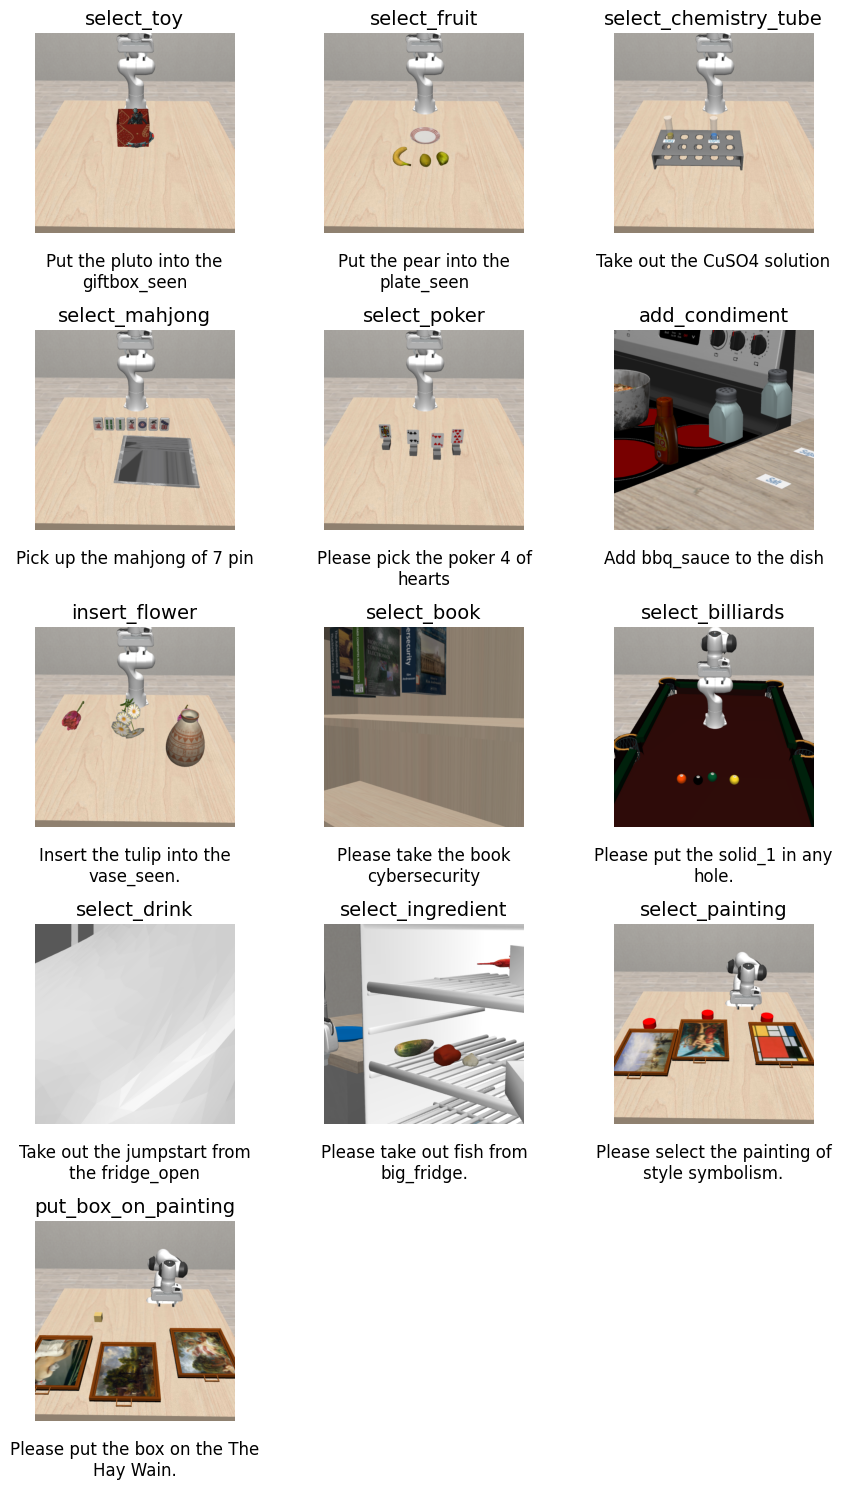

In [9]:
tasks_to_load = ["select_toy", "select_fruit", "select_chemistry_tube", "select_mahjong", "select_poker", "add_condiment", "insert_flower", "select_book", "select_billiards", "select_drink", "select_ingredient", "select_painting","put_box_on_painting"]
images, instructions = [], []
for task in tasks_to_load:
    try:
        image, instruction = load_env_and_render(task, robot, reset_wait_step=0)
        images.append(image)
        instructions.append(instruction)
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"Failed to load task {task}: {e}")
plot_images(images, instructions, titles=tasks_to_load, max_columns=3)


### 2.2 Common Sense & World Knowledge

The base environment for Common Sense & World Knowledge type tasks quering LLM to generate task instructions by default. We also recommend to generate the instructions in batch later.

In [10]:
tasks_to_load = ["hammer_loose_nail"]

### 2.3 Spatial Understanding

The base environment for spatial understanding generate the relative spatial relationships between target entity and other entities by task-specific rules.

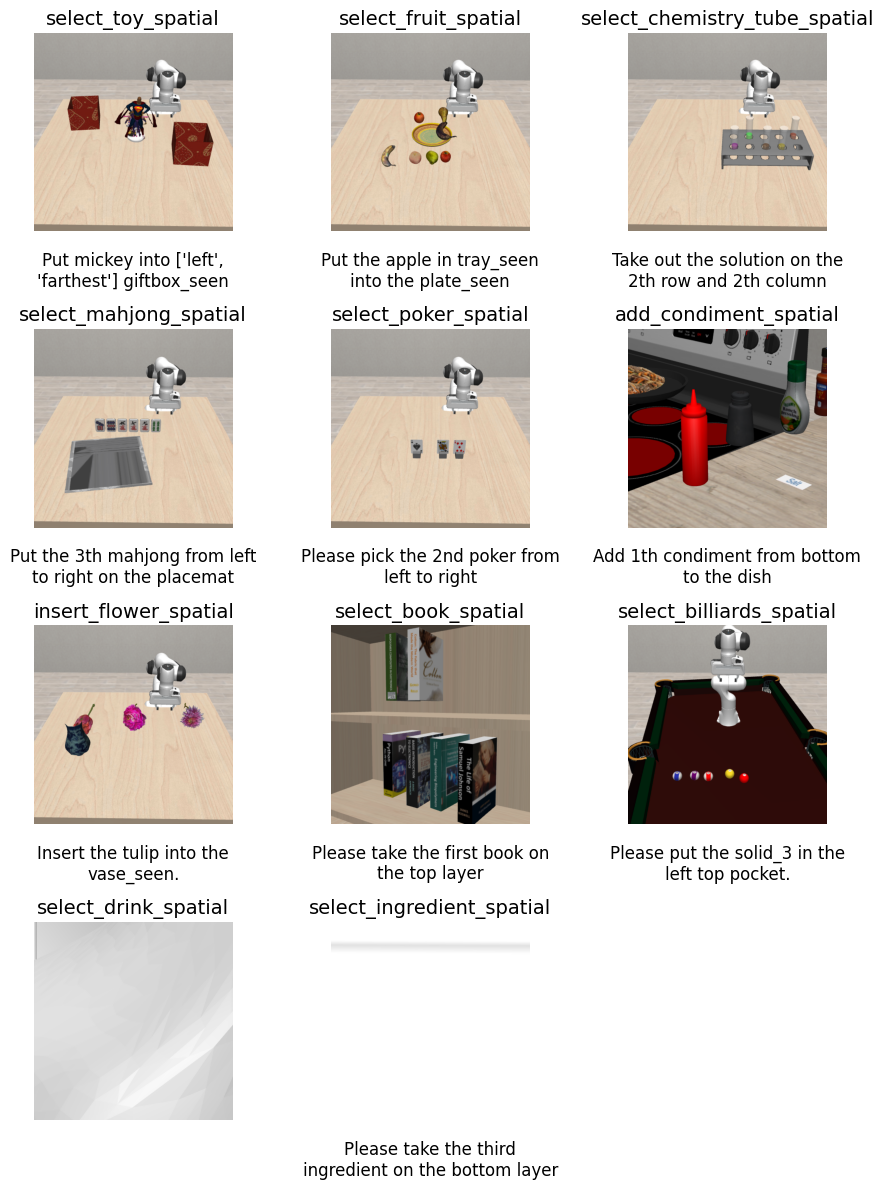

In [11]:
tasks_to_load = ["select_toy_spatial", "select_fruit_spatial", "select_chemistry_tube_spatial", "select_mahjong_spatial", "select_poker_spatial", "add_condiment_spatial", "insert_flower_spatial", "select_book_spatial", "select_billiards_spatial", "select_drink_spatial", "select_ingredient_spatial"]
# "", "select_poker", "add_condiment", "insert_flower", "select_book", "select_billiards", "select_drink", "select_ingredient", "select_painting","put_box_on_painting"
images, instructions = [], []
robot="franka"
for task in tasks_to_load:
    try:
        image, instruction = load_env_and_render(task, robot, reset_wait_step=0)
        images.append(image)
        instructions.append(instruction)
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"Failed to load task {task}: {e}")
plot_images(images, instructions, titles=tasks_to_load, max_columns=3)

### 2.4 Semantic Understanding

In [15]:
tasks_to_load = ["select_toy_semantic", "select_fruit_semantic"]
for task in tasks_to_load:
    try:
        image, instruction = load_env_and_render(task, robot, reset_wait_step=0)
        images.append(image)
        instructions.append(instruction)
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"Failed to load task {task}: {e}")


In [16]:
instructions

["Put mickey into ['left', 'farthest'] giftbox_seen",
 'Put the apple in tray_seen into the plate_seen',
 'Take out the solution on the 2th row and 2th column',
 'Put the 3th mahjong from left to right on the placemat',
 'Please pick the 2nd poker from left to right',
 'Add 1th condiment from bottom to the dish',
 'Insert the tulip into the vase_seen.',
 'Please take the first book on the top layer',
 'Please put the solid_3 in the left top pocket.',
 '',
 'Please take the third ingredient on the bottom layer',
 "It's a conversation",
 "tell some specifics of banana between ['banana', 'peach', 'orange']"]

## 3.Overview of Composite Tasks

### 3.1Cluster series tasks

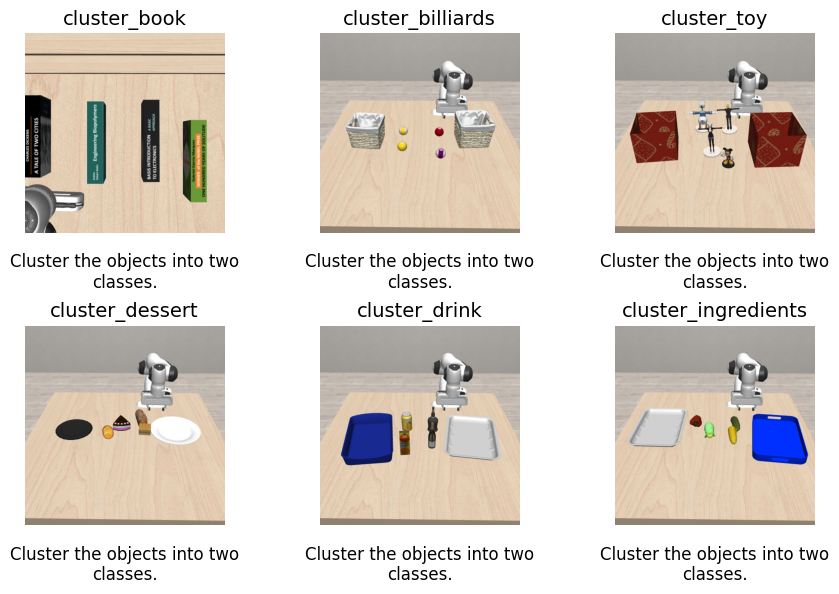

In [17]:
tasks_to_load = ["cluster_book", "cluster_billiards", "cluster_toy", "cluster_dessert", "cluster_drink", "cluster_ingredients"]
images, instructions = [], []
for task in tasks_to_load:
    image, instruction = load_env_and_render(task, robot, reset_wait_step=0)
    images.append(image)
    instructions.append(instruction)
plot_images(images, instructions, titles=tasks_to_load, max_columns=3)

### 3.2 Other Composite Tasks 

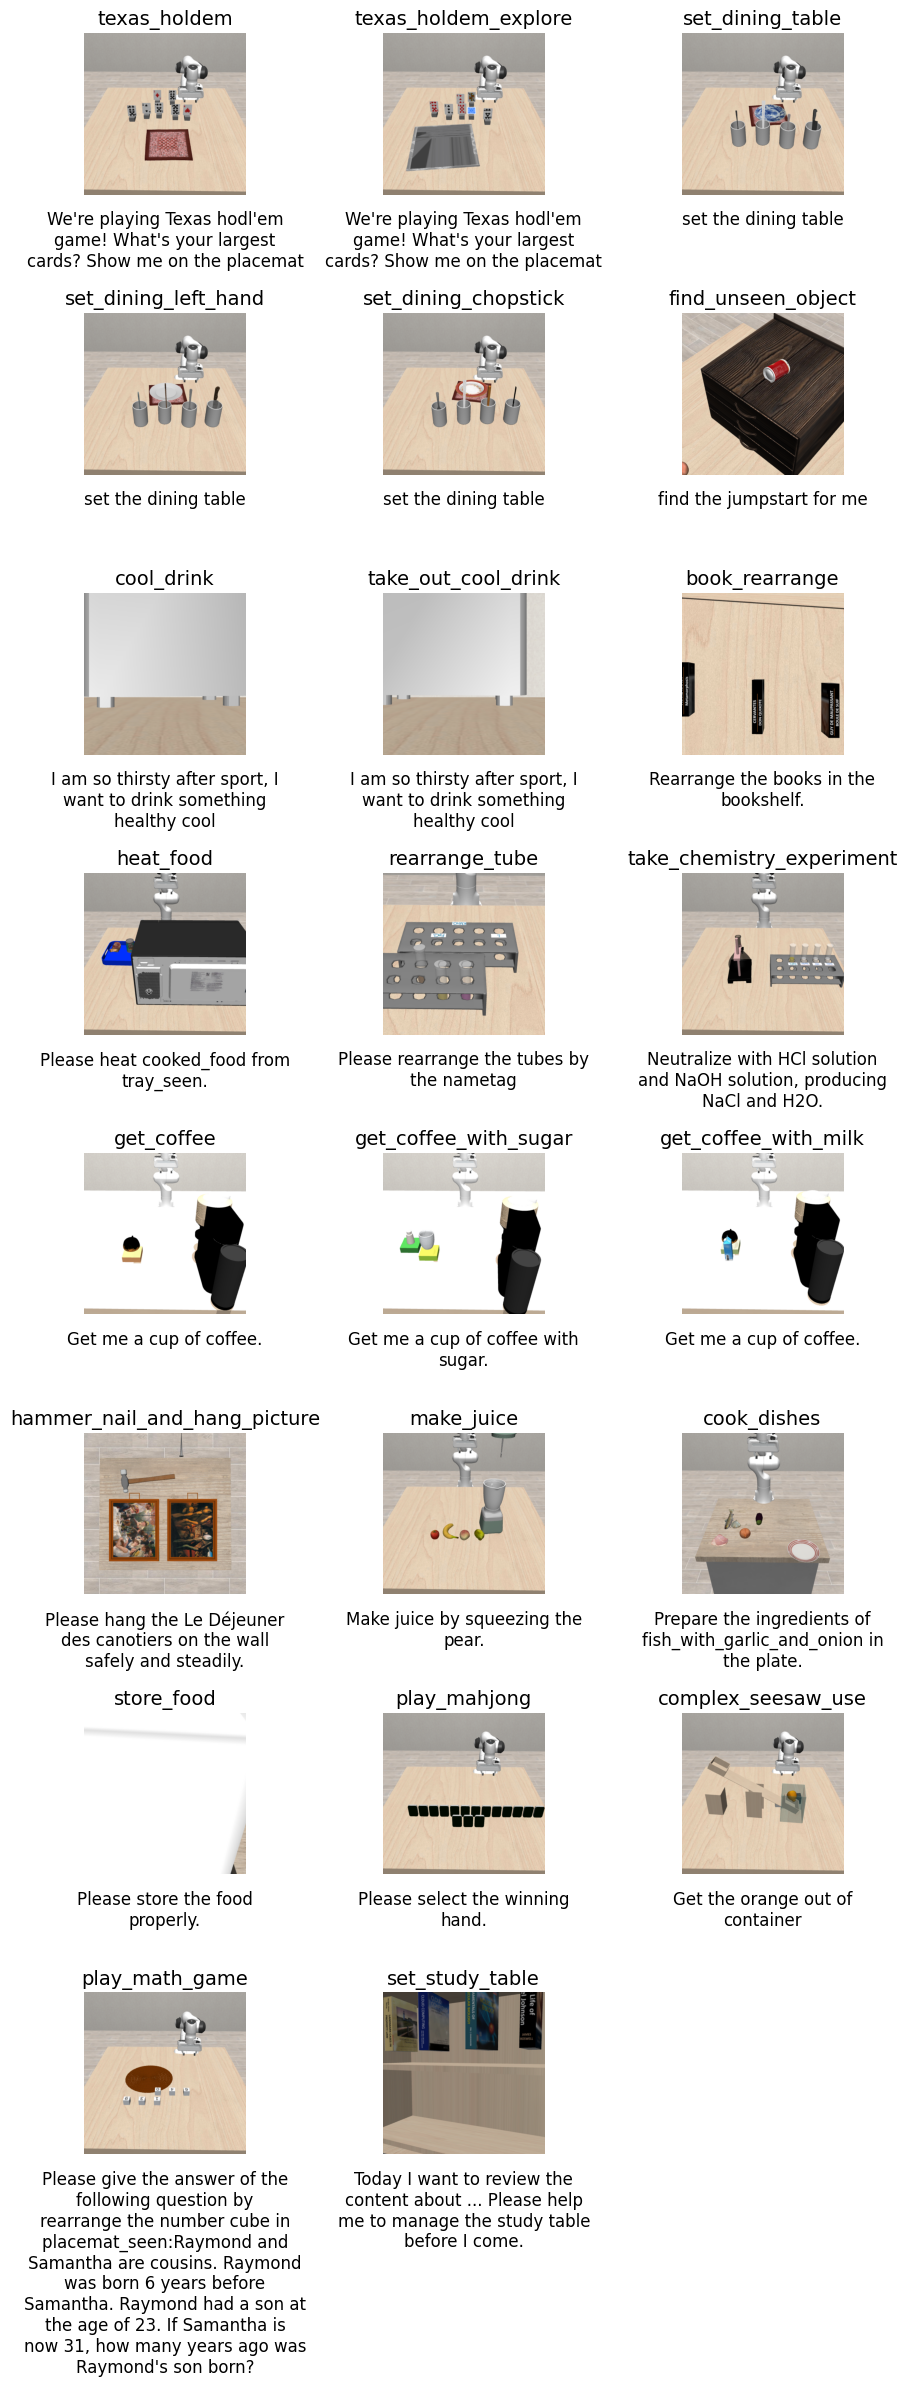

In [18]:
tasks_to_load = ["texas_holdem", "texas_holdem_explore", "set_dining_table", "set_dining_left_hand", "set_dining_chopstick", "find_unseen_object", "cool_drink", "take_out_cool_drink", "book_rearrange", "heat_food", "rearrange_tube", "take_chemistry_experiment", "get_coffee", "get_coffee_with_sugar", "get_coffee_with_milk", "hammer_nail_and_hang_picture", "make_juice", "cook_dishes", "store_food", "play_mahjong", "complex_seesaw_use", "play_math_game", "set_study_table"]
images, instructions = [], []
for task in tasks_to_load:
    image, instruction = load_env_and_render(task, robot, reset_wait_step=0)
    images.append(image)
    instructions.append(instruction)
plot_images(images, instructions, titles=tasks_to_load, max_columns=3)